In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
#!unrar x /content/drive/MyDrive/data.rar

In [6]:
import numpy as np
import tensorflow as tf
import numpy as np
import os

In [7]:
import pathlib
data_dir = pathlib.Path("../raw_data/data")

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

375974


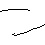

In [9]:
import PIL
import PIL.Image

equal_sign = list(data_dir.glob('=/*'))
PIL.Image.open(str(equal_sign[10]))

In [10]:
batch_size = 32
img_height = 45
img_width = 45

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.


2022-06-03 12:22:07.580558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 75194 files for validation.


In [13]:
train_ds.class_names

['!',
 '(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'Delta',
 'G',
 'H',
 'M',
 'N',
 'R',
 'S',
 'T',
 'X',
 '[',
 ']',
 'alpha',
 'ascii_124',
 'b',
 'beta',
 'cos',
 'd',
 'div',
 'e',
 'exists',
 'f',
 'forall',
 'forward_slash',
 'gamma',
 'geq',
 'gt',
 'i',
 'in',
 'infty',
 'int',
 'j',
 'k',
 'l',
 'lambda',
 'ldots',
 'leq',
 'lim',
 'log',
 'lt',
 'mu',
 'neq',
 'o',
 'p',
 'phi',
 'pi',
 'pm',
 'prime',
 'q',
 'rightarrow',
 'sigma',
 'sin',
 'sqrt',
 'sum',
 'tan',
 'theta',
 'times',
 'u',
 'v',
 'w',
 'y',
 'z',
 '{',
 '}']

In [14]:
class_names = tuple(train_ds.class_names)
print(class_names)

('!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}')


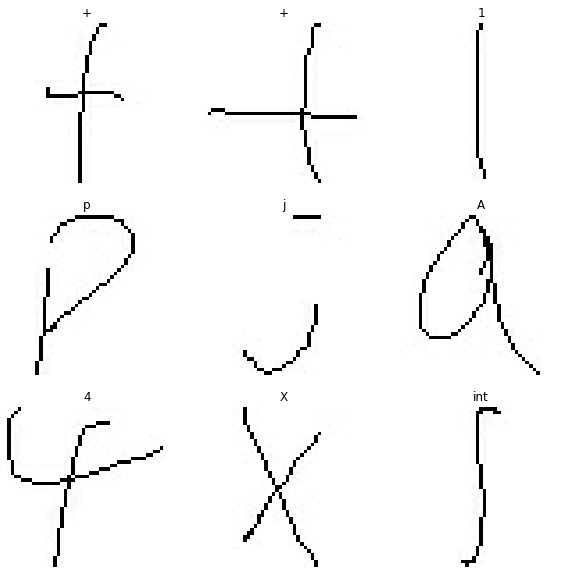

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 45, 45, 3)
(32,)


In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = 82

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
%%time
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
).history

Epoch 1/3
9400/9400 [==============================] - 564s 60ms/step - loss: 0.5908 - accuracy: 0.8359 - val_loss: 0.3655 - val_accuracy: 0.8939
Epoch 2/3
9037/9400 [===========================>..] - ETA: 17s - loss: 0.3107 - accuracy: 0.9047

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
model.summary()

In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [ ]:
print(prediction_scores)

In [ ]:
!pip install opencv-python

In [ ]:
%load_ext autoreload
%autoreload 2
from get_test_data import test_data
import cv2

In [ ]:
num=test_data("IMG_5023 copy 2.jpeg")[1]

In [141]:
num2 = tf.image.rgb_to_grayscale(num)
num2= tf.image.grayscale_to_rgb(num2)
num2.shape

TensorShape([45, 45, 3])

In [142]:
prediction_scores= model.predict(np.expand_dims(num2, axis=0))
predicted_index = np.argmax(prediction_scores)
print("Predicted label: " + class_names[predicted_index])

1/1 [==============================] - 0s 27ms/step
Predicted label: +


In [70]:
# https://www.tensorflow.org/tutorials/load_data/images